In [1]:
# Basics
import pandas as pd
import numpy as np
import os
import geopy

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Pipeline 
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

# Split
from sklearn.model_selection import train_test_split

# Baseline
from sklearn.metrics import mean_absolute_error
# Tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

C:\Users\GPARR\.virtualenvs\Build_week_Airbnb-vpv41VED\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [4]:
pd.set_option('display.max_columns', None)

In [6]:
#           ### CONCAT FILES IN CSVs FOLDER ###

# files = [file_path for file_path in os.listdir('Seasons Data/Spring') if file_path.endswith('.csv')]

# df = pd.read_csv(os.path.join('Seasons Data/Spring', files[0]))

# for csv_path in files[1:]:
#     df_to_add = pd.read_csv(os.path.join('Seasons Data/Spring', csv_path))
#     df = pd.concat([df,df_to_add])
    
    
# #df.reset_index(drop=True, inplace=True)

# df.to_csv('Spring_Data.csv')

In [196]:
COLS = ['picture_url','description','has_availability','host_since','host_response_time','host_is_superhost', 'host_listings_count',
        'host_has_profile_pic', 'host_identity_verified', 'latitude','longitude', 'room_type', 'accommodates','bathrooms_text', 'bedrooms', 'beds', 'amenities',
        'price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_l30d',
        'review_scores_rating', 'instant_bookable','reviews_per_month']

def wrangle_data(PATH):
    df = pd.read_csv(PATH, usecols=COLS, low_memory=False)
    
    df = df[df['has_availability'] == 't']
    
#     df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).apply(lambda x: x.replace('%','') if x!='nan' else np.nan)
#     df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float)/100
    
    df['host_since'] = pd.to_datetime(df['host_since']).dt.year
    
    # Bool Columns
    df['host_is_superhost'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['host_is_superhost']]
    df['host_has_profile_pic'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['host_has_profile_pic']]
    df['host_identity_verified'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['host_identity_verified']]
    df['instant_bookable'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['instant_bookable']]
    
    
    df['description_len'] = df['description'].astype(str).apply(lambda x: len(x) if x!='nan' else np.nan)
    
    df['n_amenities'] = df['amenities'].apply(lambda x: len(x.strip('][').split(', ')) if len(x)>2 else np.nan)

    df['n_bathrooms'] = [np.nan if i=='nan' else
                         0.5 if i.split()[0]=='Half-bath' else
                         1.0 if i.split()[0] in ['Private','Shared'] else
                         float(i.split()[0]) for i in df['bathrooms_text'].astype(str)]
    
    df['price'] = df['price'].apply(lambda x: x.replace('$','').replace(',',''))
    df['price'] = df['price'].astype(float)
    
    # Engineer Features
    df['baths_are_shared'] = [np.nan if i=='nan' else True if i.count('shared')!=0 else False for i in df['bathrooms_text'].astype(str)]
    
    df['multi_listing_host'] = [np.nan if i==np.nan else True if i>1 else False for i in df['host_listings_count']]
    
    
    df.drop(columns=['has_availability','description', 'amenities','bathrooms_text', 'host_listings_count'], inplace=True)
    
    # Rename Columns
    df.columns = ['picture_url', 'host_since', 'response_time', 'superhost',
       'host_profile_pic', 'id_verified', 'lat',
       'lon', 'room_type', 'accommodates', 'n_bedrooms', 'n_beds', 'price',
       'min_nights', 'max_nights', 'total_reviews',
       'n_reviews_l30d', 'reviews_rating', 'instant_bookable',
       'reviews_per_month', 'description_len', 'n_amenities', 'n_baths',
       'shared_baths', 'multi_listing_host']
    
    # Reorder Columns
    df = df[['lat', 'lon','host_since','room_type','response_time','picture_url','host_profile_pic','id_verified','superhost','instant_bookable',
             'multi_listing_host','description_len','n_amenities','accommodates','n_bedrooms','n_beds','n_baths','shared_baths','min_nights', 'max_nights','n_reviews_l30d',
             'reviews_per_month','total_reviews','reviews_rating','price']]
    
    #Filtering Outliers From
    # price Column
    df = df[(df['price'] >= df['price'].quantile(0.04)) & (df['price'] <= df['price'].quantile(0.96))]
    # min_nights Column
    df = df[(df['min_nights'] >= df['min_nights'].quantile(0.01)) & (df['min_nights'] <= df['min_nights'].quantile(0.99))]
    # max_nights Column
    df = df[(df['max_nights'] >= df['max_nights'].quantile(0.001)) & (df['max_nights'] <= df['max_nights'].quantile(0.99))]
    # n_amenities Column
    df = df[(df['n_amenities'] >= df['n_amenities'].quantile(0.005)) & (df['n_amenities'] <= df['n_amenities'].quantile(0.999))]
    # n_baths Column
    df = df[(df['n_baths'] >= df['n_baths'].quantile(0.0001)) & (df['n_baths'] <= df['n_baths'].quantile(0.9999))]
#     # n_beds Column
#     df = df[(df['n_beds'] >= df['n_beds'].quantile(0.01)) & (df['n_beds'] <= df['n_beds'].quantile(0.99))]
    # description_len Column
    df = df[(df['description_len'] >= df['description_len'].quantile(0.01)) & (df['description_len'] <= df['description_len'].quantile(0.99))]
#     # reviews_per_month Column
#     df = df[df['reviews_per_month'] <= df['reviews_per_month'].quantile(0.9999)]
    
    # Null Values
    df['response_time'][df['response_time'].isnull()] = 'within an hour'
    df = df[df['host_profile_pic'].notnull() & df['superhost'].notnull() & df['id_verified'].notnull()]
    
    
    # #Scale Columns
    # df['log_reviews_per_month'] = [np.nan if i==np.nan else 0 if i==0 else np.log(i) for i in df['reviews_per_month']]
    # df['log_total_reviews'] = [np.nan if i==np.nan else 0 if i==0 else np.log(i) for i in df['total_reviews']]
    
    #Drop Highly Correlated Features & last min drops
    df.drop(columns=['n_reviews_l30d', 'picture_url'], inplace=True)
    
    
    
    return df

In [197]:
Winter_df = wrangle_data('Concat_CSVs/Winter_Data.csv')
# Spring_df = wrangle_data('Concat_CSVs/Spring_Data.csv')
# Summer_df = wrangle_data('Concat_CSVs/Summer_Data.csv')
# Fall_df = wrangle_data('Concat_CSVs/Fall_Data.csv')

In [198]:
 round(Spring_df['price'].mean()), round(Summer_df['price'].mean()), round(Fall_df['price'].mean()), round(Winter_df['price'].mean())

(164, 181, 186, 191)

In [199]:
Winter_df.head()

,lat,lon,host_since,room_type,response_time,host_profile_pic,id_verified,superhost,instant_bookable,multi_listing_host,description_len,n_amenities,accommodates,n_bedrooms,n_beds,n_baths,shared_baths,min_nights,max_nights,reviews_per_month,total_reviews,reviews_rating,price
0,35.60670,-82.55563,2010.0,Entire home/apt,within an hour,True,True,False,False,True,1000.0,40.0,2,1.0,1.0,1.0,False,30,365,0.71,89,4.49,120.0
1,35.57864,-82.59578,2011.0,Entire home/apt,within an hour,True,True,False,True,True,759.0,26.0,2,1.0,1.0,1.0,False,1,365,2.75,347,4.57,90.0
2,35.57864,-82.59578,2011.0,Private room,within an hour,True,True,False,True,True,647.0,20.0,2,1.0,1.0,2.5,True,1,365,0.54,67,4.52,66.0
5,35.57808,-82.63689,2011.0,Private room,within a few hours,True,True,False,False,False,1000.0,40.0,2,1.0,1.0,1.0,False,2,4,0.37,42,4.98,45.0
6,35.61856,-82.55276,2011.0,Entire home/apt,within a day,True,True,False,False,False,1000.0,35.0,4,1.0,2.0,1.0,False,30,360,0.46,57,4.87,134.0


In [200]:
Winter_df['response_time'].value_counts()

within an hour        148784
within a few hours     21812
within a day           12161
a few days or more      4527
Name: response_time, dtype: int64

In [201]:
Winter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187284 entries, 0 to 216312
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   lat                 187284 non-null  float64
 1   lon                 187284 non-null  float64
 2   host_since          187284 non-null  float64
 3   room_type           187284 non-null  object 
 4   response_time       187284 non-null  object 
 5   host_profile_pic    187284 non-null  object 
 6   id_verified         187284 non-null  object 
 7   superhost           187284 non-null  object 
 8   instant_bookable    187284 non-null  bool   
 9   multi_listing_host  187284 non-null  bool   
 10  description_len     187284 non-null  float64
 11  n_amenities         187284 non-null  float64
 12  accommodates        187284 non-null  int64  
 13  n_bedrooms          168114 non-null  float64
 14  n_beds              181289 non-null  float64
 15  n_baths             187284 non-nul

In [202]:
Winter_df.describe()

,lat,lon,host_since,description_len,n_amenities,accommodates,n_bedrooms,n_beds,n_baths,min_nights,max_nights,reviews_per_month,total_reviews,reviews_rating,price
count,187284.000000,187284.000000,187284.000000,187284.000000,187284.000000,187284.000000,168114.000000,181289.000000,187284.000000,187284.000000,187284.000000,154131.000000,187284.000000,154131.000000,187284.000000
mean,34.941816,-104.774059,2015.932552,815.561372,30.840184,4.015767,1.697842,2.219020,1.405918,11.452180,600.998190,1.834199,41.870192,4.723273,190.974621
std,6.942543,26.578559,2.729930,269.937560,12.822077,2.530220,0.992013,1.622493,0.710716,15.028071,503.637901,3.138779,75.115386,0.549222,142.181187
min,18.920250,-159.714620,2008.000000,60.000000,5.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.010000,0.000000,0.000000,40.000000
25%,30.394893,-118.598905,2014.000000,617.000000,21.000000,2.000000,1.000000,1.000000,1.000000,2.000000,45.000000,0.330000,1.000000,4.670000,93.000000
50%,36.114040,-105.021480,2016.000000,1000.000000,30.000000,4.000000,1.000000,2.000000,1.000000,3.000000,365.000000,1.030000,11.000000,4.870000,148.000000
75%,40.694952,-80.091377,2018.000000,1000.000000,39.000000,5.000000,2.000000,3.000000,2.000000,30.000000,1125.000000,2.490000,48.000000,5.000000,243.000000
max,47.734034,-70.997810,2021.000000,1000.000000,76.000000,16.000000,13.000000,32.000000,11.000000,91.000000,1125.000000,362.000000,1623.000000,5.000000,800.000000


# **Select Target ( X,y = FM,TV )**

In [203]:
X = Winter_df.drop(columns=['price'])
y = Winter_df['price']

Text(0.5, 1.0, 'Features Correlation')

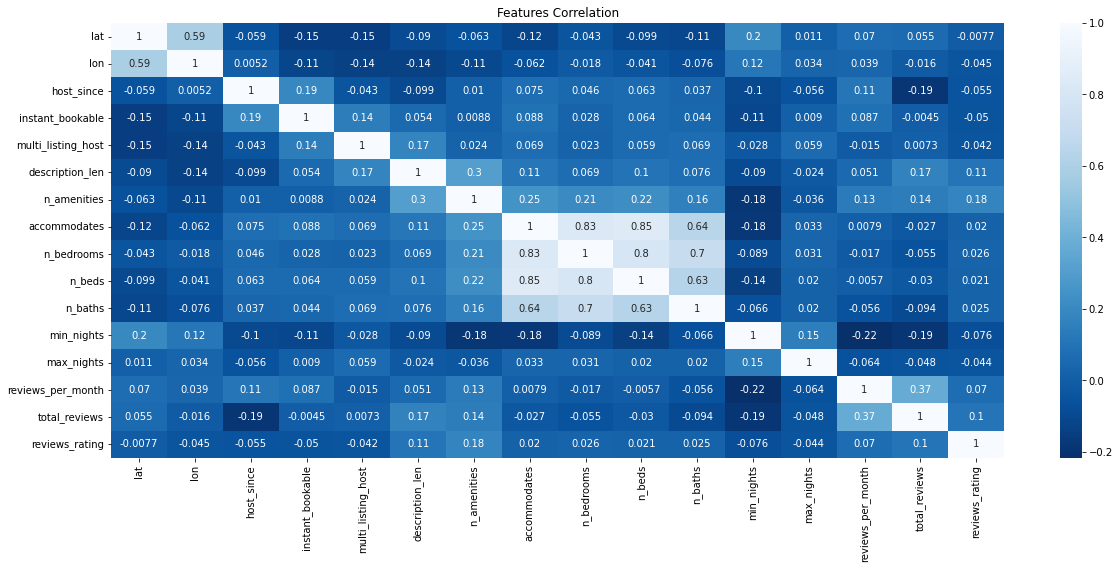

In [204]:
plt.figure(figsize=(20,8))
sns.heatmap(X.corr(), annot=True, cmap="Blues_r")
plt.title('Features Correlation')

Text(0.5, 1.0, 'Scaled Feature (reviews_per_month)')

<Figure size 1440x576 with 0 Axes>

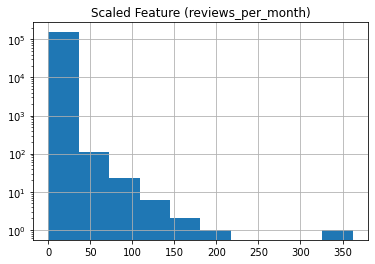

In [205]:
plt.figure(figsize=(20,8))
Winter_df.hist('reviews_per_month', log = True)  #(X.corr(), annot=True, cmap="Blues_r")
plt.title('Scaled Feature (reviews_per_month)')

Text(0.5, 1.0, 'Scaled Feature (total_reviews)')

<Figure size 1440x576 with 0 Axes>

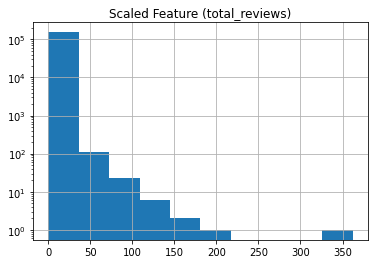

In [206]:
plt.figure(figsize=(20,8))
Winter_df.hist('reviews_per_month', log = True)  #(X.corr(), annot=True, cmap="Blues_r")
plt.title('Scaled Feature (total_reviews)')

In [207]:
# import urllib.request

# from PIL import Image

# def resolution_of_img(list1):
#     list1_res=[]
#     for i in list1:
#         urllib.request.urlretrieve(i, 'file_name')

#         img = Image.open('file_name')

#         wid, hgt = img.size
#         list1_res.append(wid*hgt)

#     return list1_res

In [208]:
# mask = [True if i[-4:].lower()=='.jpg' else False for i in df['picture_url']]
# len(df['picture_url'])

In [209]:
# resolution_of_img(list(df['picture_url']))

# **Split Data**

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [211]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((149827, 22), (37457, 22), (149827,), (37457,))

# **SET BASELINE**

In [212]:
y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE: ',mean_absolute_error(y_train,y_pred))

Baseline MAE:  105.3189369176695


# **Models Pipeline**

In [213]:
model_lr =  make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LinearRegression()
) 


model_rd = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)

model_rfr = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_jobs=-1, random_state=42)
)

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(n_jobs=-1, random_state=42,objective ='reg:squarederror')
)


# **Fitting Models**

In [214]:
model_lr.fit(X_train,y_train);
model_rd.fit(X_train,y_train);
model_rfr.fit(X_train,y_train);
model_xgb.fit(X_train,y_train);

# **Checking and Comparing Metrics**

In [215]:
def check_metrics(model):
  #print(model)
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))
  print('Test R^2:', model.score(X_test, y_test))
  print()
  print()

models = [model_lr, model_rd, model_rfr, model_xgb]
models_name = ['LinearRegression:','Ridge:','RandomForestRegressor','XGBRegressor:']
for i in range(4):
  print(models_name[i])
  check_metrics(models[i])

LinearRegression:
Training MAE: 75.23058780871183
Test MAE: 74.22455341591001
Test R^2: 0.43589578004638074


Ridge:
Training MAE: 75.23055887319563
Test MAE: 74.22449775859488
Test R^2: 0.4358959018060806


RandomForestRegressor
Training MAE: 19.702417788325697
Test MAE: 53.072504456998516
Test R^2: 0.6570248622207484


XGBRegressor:
Training MAE: 51.217308855495084
Test MAE: 55.29040473576245
Test R^2: 0.643679196401723




In [216]:
# Lists to Plot Models
models = [model_lr, model_rd, model_rfr, model_xgb]
models_type = ['Linear', 'Ridge', 'RForest', 'XGB']
Training_MAEs = []
Test_MAEs = []
models_R2s = []

def listing_metrics(model):
  # Fill lists to plot and compare models
  Training_MAEs.append(mean_absolute_error(y_train, model.predict(X_train)))
  Test_MAEs.append(mean_absolute_error(y_test, model.predict(X_test)))
  models_R2s.append(model.score(X_test, y_test))

for m in models:
  listing_metrics(m)

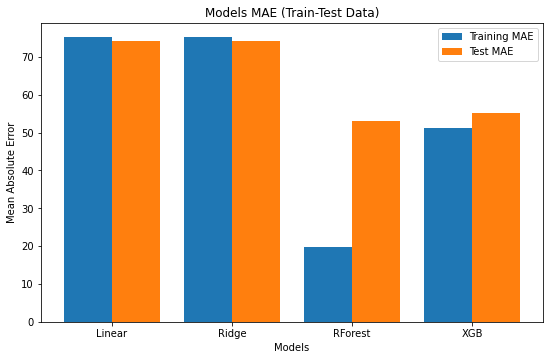

In [217]:
# Plot Models MAEs
w = 0.4
bar1 = np.arange(len(models_type))
bar2 = [i + w for i in bar1]


plt.figure(figsize=(9,5.5))
plt.bar(bar1, Training_MAEs, w, label='Training MAE')
plt.bar(bar2, Test_MAEs, w, label='Test MAE')

plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(bar1+(w/2), models_type)
plt.legend()
plt.title('Models MAE (Train-Test Data)')

plt.show()

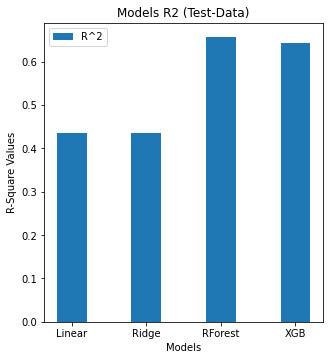

In [219]:
# Plot Models R^2s
w = 0.4
bar1 = np.arange(len(models_type))

plt.figure(figsize=(5,5.5))
plt.bar(bar1, models_R2s, w, label='R^2')

plt.xlabel('Models')
plt.ylabel('R-Square Values')
plt.xticks(bar1, models_type)
plt.legend()
plt.title('Models R2 (Test-Data)')

plt.show()

# **Tunning Random Forest Regressor**

In [230]:
param_grid = {"randomforestregressor__n_estimators": range(116,117),
              "randomforestregressor__min_samples_split": [6],
              "randomforestregressor__min_samples_leaf": [1],
              "randomforestregressor__max_samples":  [0.5],
              "randomforestregressor__max_features":['log2'],
              "randomforestregressor__max_depth": range(20,21),  
              "randomforestregressor__bootstrap": [True]
              
             }
model_rfr_search = GridSearchCV(
    model_rfr,
    param_grid = param_grid,
    cv=5,
    verbose=1# status updates
)

# Fit it to the data
model_rfr_search.fit(X, y);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [231]:
model_rfr_search.best_params_

{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_depth': 20,
 'randomforestregressor__max_features': 'log2',
 'randomforestregressor__max_samples': 0.5,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 6,
 'randomforestregressor__n_estimators': 116}

In [232]:
check_metrics(model_rfr_search)

print('Test MAE:', mean_absolute_error(y_test, model_rfr_search.predict(X_test)))
print('Test R^2:', model_rfr_search.score(X_test,y_test))

Training MAE: 45.95287140754524
Test MAE: 45.83772178213791
Test R^2: 0.7668395232549585


Test MAE: 45.83772178213791
Test R^2: 0.7668395232549585


# **Tunning Ridge Regressor**

In [234]:
param_grid = {"ridge__alpha": range(1,10),
              "ridge__fit_intercept": [True,False]
             }

model_rd_search = GridSearchCV(
    model_rd,
    param_grid = param_grid,
    cv=5,
    verbose=1# status updates
)

# Fit it to the data
model_rd_search.fit(X, y);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [235]:
model_rd_search.best_params_

{'ridge__alpha': 9, 'ridge__fit_intercept': True}

In [236]:
check_metrics(model_rd_search)

print('Test MAE:', mean_absolute_error(y_test, model_rd_search.predict(X_test)))
print('Test R^2:', model_rd_search.score(X_test,y_test))

Training MAE: 75.22088368249234
Test MAE: 74.20552740000342
Test R^2: 0.4360108249916749


Test MAE: 74.20552740000342
Test R^2: 0.4360108249916749
